# Homework 2

In [1]:
import rpy2
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1337)
%load_ext rpy2.ipython

In [2]:
%%R -o d
# Make sure we have correct R library path
.libPaths("C:/Users/ville_000/Documents/R/win-library/3.6")
library(rstan)
library(rethinking)
data(Howell1)
d = Howell1

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Stuff from lecture

### Data pre-processing

In [3]:
from sklearn.preprocessing import StandardScaler
d['weight_s'] = StandardScaler().fit_transform(d[['weight']].values)
d['weight_s2'] = np.power(d['weight_s'], 2)

# Frame with only adults in it
d_adults = d[d["age"] >= 18]

### Exploring data

In [4]:
d.head()

,height,weight,age,male,weight_s,weight_s2
0,151.76,47.83,63.00,1,0.83,0.69
1,139.70,36.49,63.00,0,0.06,0.00
2,136.53,31.86,65.00,0,-0.25,0.06
3,156.84,53.04,41.00,1,1.19,1.41
4,145.41,41.28,51.00,0,0.39,0.15


In [5]:
d.describe()

,height,weight,age,male,weight_s,weight_s2
count,544.00,544.00,544.00,544.00,544.00,544.00
mean,138.26,35.61,29.34,0.47,-0.00,1.00
std,27.60,14.72,20.75,0.50,1.00,1.03
min,53.98,4.25,0.00,0.00,-2.13,0.00
25%,125.09,22.01,12.00,0.00,-0.93,0.19
50%,148.59,40.06,27.00,0.00,0.30,0.66
75%,157.48,47.21,43.00,1.00,0.79,1.51
max,179.07,62.99,88.00,1.00,1.86,4.55


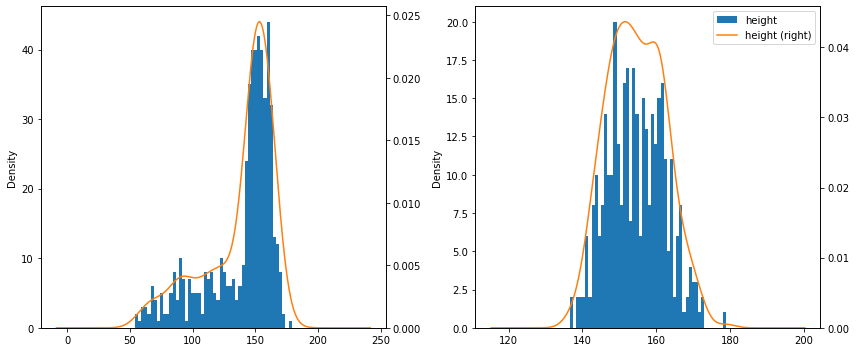

In [6]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
_ = d["height"].plot.hist(ax=ax, bins=50)
_ = d["height"].plot.kde(ax=ax, secondary_y=True)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
ax = fig.add_subplot(122)
_ = d.loc[d["age"]>=18,["height"]].plot.hist(ax=ax, bins=50)
_ = d.loc[d["age"]>=18,["height"]].plot.kde(ax=ax, secondary_y=True)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
plt.tight_layout()

### Model for height (*model_1*)

Gaussian model for height

\begin{align}
 h_i \sim N(\mu, \sigma)
\end{align}

Parametes $\mu$ and $\sigma$ need to be inferred from the data. In Bayesian inference, we first give some prior distributions to them.

\begin{align}
 \mu \sim N(178, 20) \\
 \sigma \sim \text{Uniform}(0, 50)
\end{align}

- Draw samples of mean heights from normal distribution. Prior mean height 178 here is arbitrary, and probably not a good one as it is higher than average Kalahari forager height.
- Draw sample of stds from uniform distribution.

Once the parameters have prior distributions, we can sample heights given the prior distributions. This is called sampling from *prior predictive distribution*: **before seeing the data, what does the model believe?**


#### Prior distributions

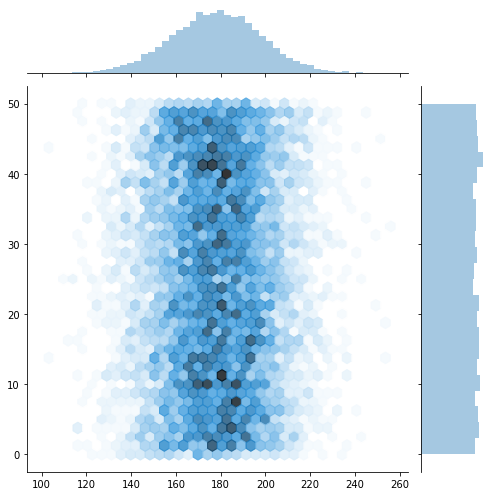

In [7]:
sample_mu = np.random.normal(loc=178, scale=20, size=10000)
sample_sigma = np.random.uniform(low=0, high=50, size=10000)
_ = sns.jointplot(sample_mu,sample_sigma, alpha = 0.8, kind = 'hex', height=7)

#### Sample from predictive prior distribution

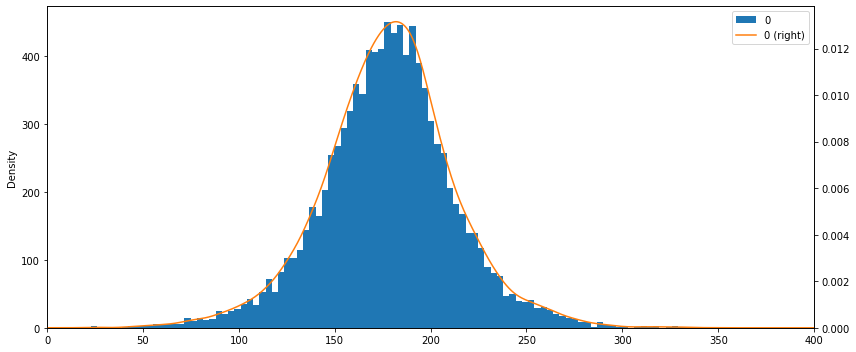

In [8]:
# Sample
prior_h = pd.DataFrame(np.random.normal(loc=sample_mu, scale=sample_sigma))
# Plot predictive prior distribution
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = prior_h.plot.hist(ax=ax, bins=100)
_ = prior_h.plot.kde(ax=ax, secondary_y=True)
_ = ax.set_xlim(0,400)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
plt.tight_layout()

#### Get posterior using grid approximation
Skip!

#### Get posterior distribution using quadratic approximation (Gaussian)

In the end, we are interested about the posterior distribution. There are essentially three ways ot calculate it. One is *quadratig approximation*: it approximates posterior as (multi-dimensional) Gaussian distribution.

Function *quap* in the rethinking package. 

In [9]:
%%R -i d_adults -o summary,sample_posterior

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu ~ dnorm(178, 20),
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior.
# Fit model contains as outcome list of parameter means and convariance matrices
# (between parameters), which is enough to describe (multi-dimensional) normal distribution
model_1 = quap(flist, data=d_adults)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary = precis(model_1)

# Draw samples of paramets from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior = extract.samples(model_1, n=10000)

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [10]:
# Print analytical results
print(summary)

        mean   sd   5.5%  94.5%

mu    154.61 0.41 153.95 155.27

sigma   7.73 0.29   7.27   8.20



,mu,sigma
count,10000.00,10000.00
mean,154.61,7.73
std,0.41,0.29
min,152.93,6.71
5.5%,153.95,7.27
50%,154.61,7.73
94.5%,155.27,8.20
max,155.94,8.90


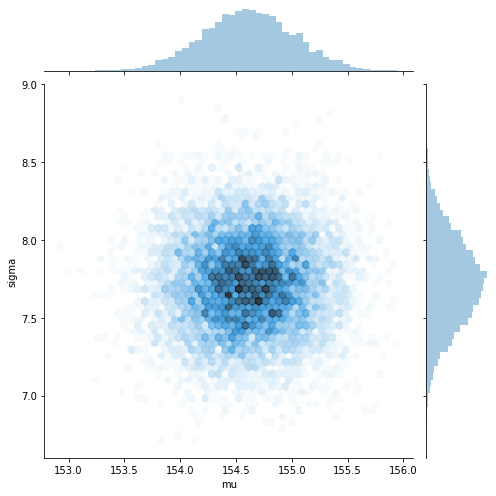

In [11]:
# Print result from drawn sample
display(sample_posterior.describe(percentiles=[0.055, 0.945]))
_ = sns.jointplot(sample_posterior['mu'],sample_posterior['sigma'], alpha = 0.8, kind = 'hex', height=7)

### Model for height with weight as predictor (*m2*)

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta (x_i - \bar{x}) \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior}  \\
 \beta \sim N(0, 10) \qquad & \text{prior} 
\end{align}

Notice we are centering the predictor, so that $\alpha$ will denote the population mean.

In [12]:
# Hundred draws out pf prior predictive distribution
N = 100
# Sample mean weight
xbar = d_adults["weight"].mean()

# Define grid over which we evaluate (prior) predictive distribution
min_p = d_adults["weight"].min()
max_p = d_adults["weight"].max()
x_grid = np.arange(min_p, max_p, 0.2)

#### Prior predictive distribution for $\mu$
We notice that the prior predictive distribution for $\mu$ allows fro quite unrealistic cases.

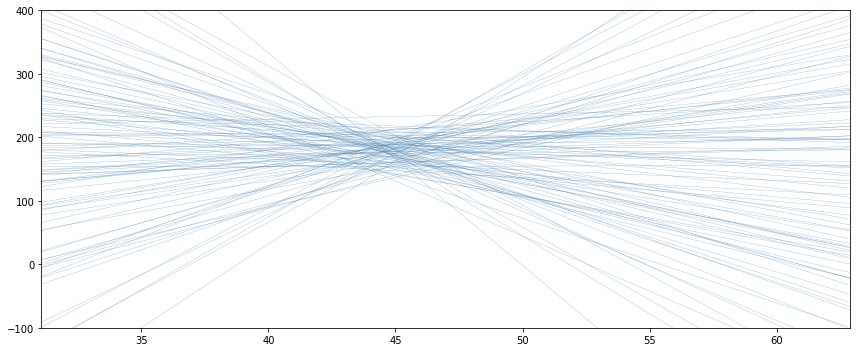

In [13]:
# Draw values for alpha and beta
alpha = np.random.normal(loc=178, scale=20, size=N)
beta = np.random.normal(loc=0, scale=10, size=N)

# Calculate mu
mu = np.empty((len(x_grid),N))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(-100,400)
plt.tight_layout()

Let's make the prior for $\beta$ better: log-normal. This yields more plausible prior predictive distribution for $\mu$.

\begin{align}
 \beta \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} 
\end{align}

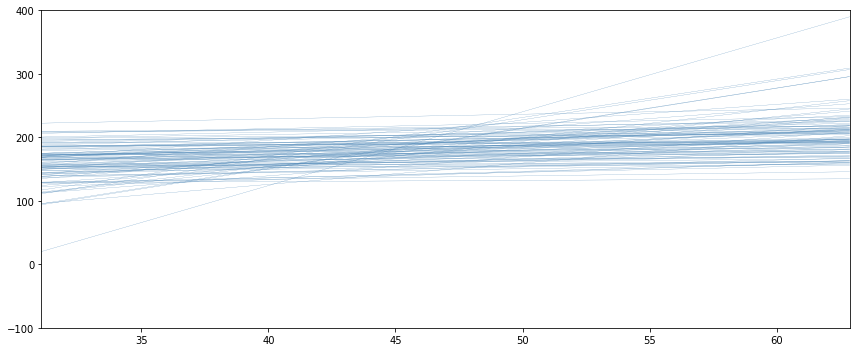

In [14]:
# Re-draw prior values for beta
beta = np.random.lognormal(mean=0, sigma=1, size=N)

# Calculate mu
mu = np.empty((len(x_grid),N))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(-100,400)
plt.tight_layout()

#### Build model using quadratig approximation

In [15]:
%%R -i d_adults,xbar -o summary_m2,sample_posterior_m2

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b * (weight - xbar),
    a ~ dnorm(178, 20),
    b ~ dlnorm(0,1),
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior
m2 = quap(flist, data=d_adults)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary_m2 = precis(m2)

# Draw samples of parameters from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior_m2 = extract.samples(m2, n=10000)

In [16]:
print(summary_m2)

        mean   sd   5.5%  94.5%

a     154.60 0.27 154.17 155.04

b       0.90 0.04   0.84   0.97

sigma   5.07 0.19   4.77   5.38



#### Predictive posterior distribution for $\mu$
This is plot weight - average height. In *rethinking* package, function *link* does the same stuff as what is done here below.

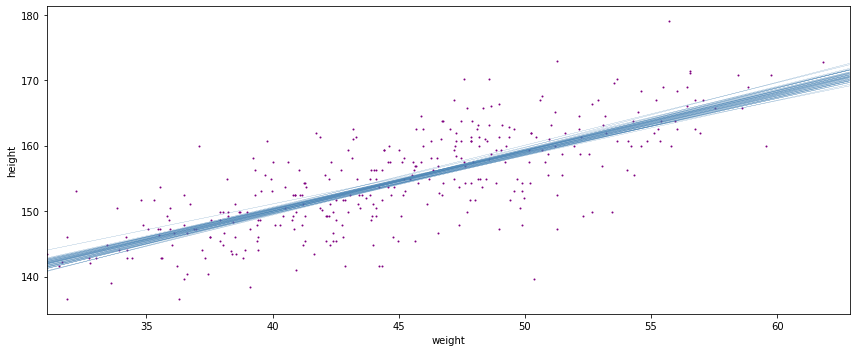

In [17]:
nolines = 50

# Draw values for alpha and beta
alpha = sample_posterior_m2['a'][:nolines]
beta = sample_posterior_m2['b'][:nolines]

# Calculate mu
mu = np.empty((len(x_grid),len(sample_posterior_m2[:nolines])))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = d_adults[['weight','height']].plot(ax=ax, kind='scatter', x='weight', y='height', s=1, c='purple')
plt.tight_layout()

## 2nd-order polynominal model (*m3*)

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta_1 x_i + \beta_2 x_{i}^{2} \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \beta_1 \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} \\
 \beta_2 \sim N(0, 1) \qquad & \text{prior}  \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior} 
\end{align}

We are using full !Kung dataset (chlidren and adults). Here $x_i$ are z-score standardized.

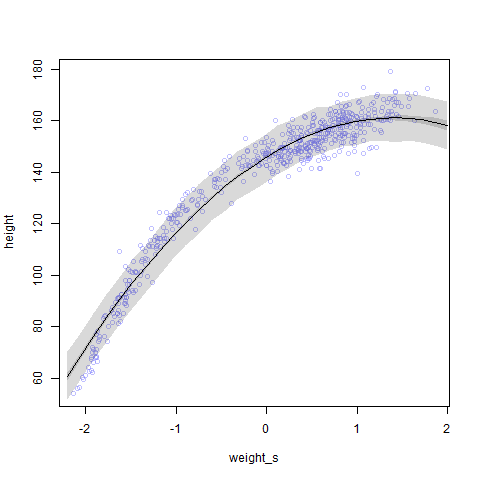

In [18]:
%%R -i d,xbar -o summary_m3,sample_posterior_m3,x_grid,mu_mean,mu_PI,height_PI

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b1 * weight_s + b2 * weight_s2,
    a ~ dnorm(178, 20),
    b1 ~ dlnorm(0,1),
    b2 ~ dnorm(0,1),    
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior
m3 = quap(flist, data=d)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary_m3 = precis(m3)

# Draw samples of parameters from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior_m3 = extract.samples(m3, n=10000)

# Calculate mu posterior draws using function link

x_grid = seq(from=-2.2, to=2, length.out=30)
exo_grid = list(weight_s=x_grid, weight_s2=x_grid^2)

# Posterior distribution for mu
mu = link(m3, data=exo_grid)

# Mean mu
mu_mean = apply(mu, 2, mean)

# To simulate observations that average over posterior distributions, use sim
sim_height = sim(m3, data=exo_grid)

# Probability intervals for mu and simualted heights
mu_PI = apply(mu, 2, PI, prob=0.89)
height_PI = apply(sim_height, 2, PI, prob=0.89)

# Plot
plot(height ~ weight_s, d, col=col.alpha(rangi2,0.5))
lines(x_grid, mu_mean)
shade(mu_PI, x_grid)
shade(height_PI, x_grid)

In [19]:
print(summary_m3)

        mean   sd   5.5%  94.5%

a     146.06 0.37 145.47 146.65

b1     21.71 0.29  21.25  22.17

b2     -7.79 0.27  -8.23  -7.35

sigma   5.77 0.18   5.49   6.06



## Question 1
*The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.*

To answer this, we'll use the sampled values from **model_2** above for $\alpha$, $\beta$.

In [20]:
weights = np.array([45, 40, 65, 31, 53])
alpha = sample_posterior_m2['a']
beta = sample_posterior_m2['b']
mu = np.empty((len(weights),len(sample_posterior_m2)))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (weights-xbar)
mu = pd.DataFrame(mu)
mu.index = weights
mu = mu.T

result = mu.describe(percentiles=[0.055, 0.945])
result[result.index.isin(["mean","5.5%","94.5%"])]

,45,40,65,31,53
mean,154.61,150.10,172.67,141.97,161.84
5.5%,154.18,149.55,171.25,140.93,161.15
94.5%,155.04,150.64,174.10,143.01,162.52


## Question 2
*Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.*